Calculate the parameters of CI

In [10]:
# using label file to classify the sinusoid noise parameters 
import numpy as np

label_f = np.loadtxt('D:\cnnface/female_male_test_51_addnoise/label_sinusoid_f.txt').astype('int64')
label_m = np.loadtxt('D:\cnnface/female_male_test_51_addnoise/label_sinusoid_m.txt').astype('int64')

paras_5000 = np.load('D:\cnnface/female_male_test_51_addnoise\Face_template\meta_data/params_5000.npy')

paras_f = paras_5000[label_f]
paras_m = paras_5000[label_m]

# average the parameters after labeling
paras_f = np.mean(paras_f,axis=0)
paras_m = np.mean(paras_m,axis=0)

# calculate the CI image from averaging
paras_ci = paras_f - paras_m

patches = np.load('D:\cnnface/female_male_test_51_addnoise\Face_template\meta_data/patches.npy')
patchIdx = np.load('D:\cnnface/female_male_test_51_addnoise\Face_template\meta_data/patchidx.npy')

Reconstruct CI image from the parameters of CI

In [11]:
# Reconstruct CI image from the parameters of CI
for i in range(4092):
    print(i)
    patchIdx[patchIdx==i+1] = paras_ci[i]
noise = np.sum(patches * patchIdx,axis=2)
print(noise.shape)
nor = lambda x:(x-x.min())/(x.max() - x.min()) 
noise = nor(noise) *255
from PIL import Image
noise_img = Image.fromarray(noise)
noise_img.show()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [236]:
# calculate the index of different frequency noise
scales = [2**i for i in range(1,5+1)]
NumPatch = [(scale / 2) ** 2 for scale in scales]
NumParam = [ int(num*12) for num in NumPatch]
print(NumParam)
l = [sum(NumParam[:i+1]) for i in range(len(NumParam))]
print(l)
idx = [i*12 for i in range(6)]
print(idx)

[12, 48, 192, 768, 3072]
[12, 60, 252, 1020, 4092]
[0, 12, 24, 36, 48, 60]


Slice the different level of frequency from CI

In [57]:
# slice the different level of frequency from ci
noise_2 = np.sum(patches[:,:,:12] * patchIdx[:,:,:12],axis=2)
noise_4 = np.sum(patches[:,:,12:24] * patchIdx[:,:,12:24],axis=2)
noise_8 = np.sum(patches[:,:,24:36] * patchIdx[:,:,24:36],axis=2)
noise_16 = np.sum(patches[:,:,36:48] * patchIdx[:,:,36:48],axis=2)
noise_32 = np.sum(patches[:,:,48:60] * patchIdx[:,:,48:60],axis=2)

noise_list = [noise_2,noise_4, noise_8, noise_16,noise_32]
nor = lambda x:(x-x.min())/(x.max() - x.min())
for i,noi in enumerate(noise_list):
     noise_list[i] = nor(noi) * 40

In [58]:
# baseface add noise or subtract noise and save the different frequency CI
from PIL import Image

frame54 = Image.open('D:\cnnface/female_male_test_51_addnoise\Face_template/face_template/frame054_gray_512.jpg')
baseFace = np.array(frame54).astype('float64')
scale = [2,4,8,16,32]
print('baseface max:{} min:{}'.format(baseFace.max(),baseFace.min()))

for s,nx in zip(scale,noise_list):
    
    bf_add = baseFace + nx
    bf_sub = baseFace - nx
    print(bf_add.max())
    print(bf_sub.min())

    bf_add = nor(bf_add) *255
    bf_sub = nor(bf_sub) *255
    
    bf_add_img = Image.fromarray(bf_add).convert('RGB')
    bf_sub_img = Image.fromarray(bf_sub).convert('RGB')
    bf_add_img.save('D:\cnnface/female_male_test_51_addnoise\Face_template\classification_noise\different_level_CI/40_CI_add_{}.jpg'.format(s))
    bf_sub_img.save('D:\cnnface/female_male_test_51_addnoise\Face_template\classification_noise\different_level_CI/40_CI_sub_{}.jpg'.format(s))


baseface max:188.0 min:0.0
215.8228848338907
-32.20744961574965
213.5419729932675
-37.113918019000934
216.2989910236756
-33.45715941006824
213.79050964686485
-40.0
215.4171798414011
-40.0


#### Multi variable linear regression model for each of the 4092 components

In [33]:
import numpy as np
import statsmodels.api as sm

x = np.load('D:\cnnface/female_male_test_51_addnoise\Face_template\meta_data/params_5000.npy')

label_f = np.loadtxt('D:\cnnface/female_male_test_51_addnoise/label_sinusoid_f.txt').astype('int64')
label_m = np.loadtxt('D:\cnnface/female_male_test_51_addnoise/label_sinusoid_m.txt').astype('int64')

y = np.arange(5000)
y[label_f] = int(0)
y[label_m] = int(1)

rm = sm.OLS(endog=y,exog=x[:,12:60]).fit()
print(rm.summary())
print('pvalues <0.05:',np.argwhere(np.array(rm.pvalues)<0.05))

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.057
Model:                            OLS   Adj. R-squared (uncentered):              0.048
Method:                 Least Squares   F-statistic:                              6.273
Date:                Fri, 11 Oct 2019   Prob (F-statistic):                    5.43e-37
Time:                        20:36:36   Log-Likelihood:                         -6502.3
No. Observations:                5000   AIC:                                  1.310e+04
Df Residuals:                    4952   BIC:                                  1.341e+04
Df Model:                          48                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Independent t test for 4092 parameters

In [256]:
import numpy as np
from scipy import stats
 
params_5000 = np.load('D:\cnnface/female_male_test_51_addnoise\Face_template\meta_data/params_5000.npy')

label_f = np.loadtxt('D:\cnnface/female_male_test_51_addnoise/label_sinusoid_f.txt').astype('int64')
label_m = np.loadtxt('D:\cnnface/female_male_test_51_addnoise/label_sinusoid_m.txt').astype('int64')

s_sum = []
p_sum= [] 
for i in range(4092):
    x_5000 = params_5000[:,i]
    x_f = x_5000[label_f]
    x_m = x_5000[label_m]
    
    s,p = stats.ttest_ind(x_f,x_m)
    s_sum.append(s)
    p_sum.append(p)

In [271]:
p_sum = np.array(p_sum)
s_sum = np.array(s_sum)
p_sum_sign = p_sum[p_sum<(0.05/4092)]
p_signIndex = np.squeeze(np.argwhere(p_sum<(0.05/4092)))
p_minIndex = np.argwhere(p_sum==p_sum.min())

# np.save('D:\cnnface/female_male_test_51_addnoise\Face_template\CI_analysis/p_signIndex',p_signIndex)
# np.save('D:\cnnface/female_male_test_51_addnoise\Face_template\CI_analysis/p_sum',p_sum)
# np.save('D:\cnnface/female_male_test_51_addnoise\Face_template\CI_analysis/s_sum',s_sum)

ValueError: x and y must be the same size

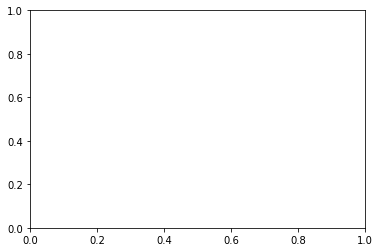

In [269]:
import matplotlib.pyplot as plt
x_5000 = params_5000[:,595]
x_f = x_5000[label_f]
x_m = x_5000[label_m]

bins = np.arange(-1,1,2/10) 
plt.hist(x_f,bins,normed=True,alpha = 0.9)
plt.hist(x_m,bins,normed=True,alpha = 0.4)
plt.savefig('D:\cnnface/female_male_test_51_addnoise\Face_template\meta_data/x_56_scatter.png')


(array([ 2.,  1.,  0.,  1.,  3., 10., 11., 29., 26., 43., 10.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-8.46672865, -8.06672865, -7.66672865, -7.26672865, -6.86672865,
        -6.46672865, -6.06672865, -5.66672865, -5.26672865, -4.86672865,
        -4.46672865, -4.06672865, -3.66672865, -3.26672865, -2.86672865,
        -2.46672865, -2.06672865, -1.66672865, -1.26672865, -0.86672865,
        -0.46672865, -0.06672865,  0.33327135,  0.73327135,  1.13327135,
         1.53327135,  1.93327135,  2.33327135,  2.73327135,  3.13327135,
         3.53327135,  3.93327135,  4.33327135,  4.73327135,  5.13327135,
         5.53327135,  5.93327135,  6.33327135,  6.73327135,  7.13327135,
         7.53327135,  7.93327135,  8.33327135,  8.73327135,  9.13327135,
         9.53327135,  9.93327135]),
 <a list of 46 Patch objects>)

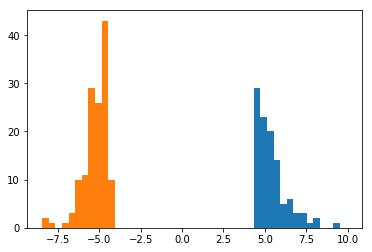

In [270]:
ss = s_sum[p_signIndex]
ss_pos = ss[ss>0]
ss_neg = ss[ss<0]

bin = np.arange(ss_neg.min(),ss_pos.max(),2/5)
plt.hist(ss_pos,bin)
plt.hist(ss_neg,bin)
#plt.savefig('D:\cnnface/female_male_test_51_addnoise\Face_template\CI_analysis/s_sign_hist.jpg')


In [254]:
scale2_pSign = p_signIndex[p_signIndex<12 ]
scale4_pSign = p_signIndex[(p_signIndex>=12) & (p_signIndex<60)]
scale8_pSign = p_signIndex[(p_signIndex>=60) & (p_signIndex<252)]
scale16_pSign = p_signIndex[(p_signIndex>=252) & (p_signIndex<1020)]
scale32_pSign = p_signIndex[(p_signIndex>=1020) & (p_signIndex<4092)]

pSign_num = [len(scale2_pSign),len(scale4_pSign),len(scale8_pSign),len(scale16_pSign),
             len(scale32_pSign)]
print(pSign_num)
plt.hist()
pSign_prop = [len(scale2_pSign)/12,len(scale4_pSign)/48,len(scale8_pSign)/192,
              len(scale16_pSign)/768,len(scale32_pSign)/3072]
print(pSign_prop)

[2, 14, 25, 40, 163]
[0.16666666666666666, 0.2916666666666667, 0.13020833333333334, 0.052083333333333336, 0.053059895833333336]


In [294]:
p_posIndex = np.intersect1d(p_signIndex,np.argwhere(s_sum>0))
p_negIndex = np.intersect1d(p_signIndex,np.argwhere(s_sum<0))
np.save('D:\cnnface/female_male_test_51_addnoise\Face_template\CI_analysis/p_posIndex',p_posIndex)
np.save('D:\cnnface/female_male_test_51_addnoise\Face_template\CI_analysis/p_negIndex',p_negIndex)

In [296]:
para_sign = np.zeros(4092)
para_sign[p_posIndex.astype('int64')] = 1
para_sign[p_posIndex.astype('int64')] = -1

#noise generate 
patches = np.load('D:\cnnface/female_male_test_51_addnoise\Face_template\meta_data/patches.npy')
patchIdx = np.load('D:\cnnface/female_male_test_51_addnoise\Face_template\meta_data/patchidx.npy')
for i in range(4092):
    if i%100 == 0:print(i)
    patchIdx[patchIdx==i+1] = para_sign[i]
noise = np.sum(patches * patchIdx,axis=2)
print(noise.shape)
nor = lambda x:(x-x.min())/(x.max() - x.min()) 
noise = nor(noise) *80
from PIL import Image
noise_img = Image.fromarray(noise)
noise_img.show()

# base face add CI

# 

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
(512, 512)


In [305]:
nor = lambda x:(x-x.min())/(x.max() - x.min()) 
noise = nor(noise) *43

frame54 = Image.open('D:\cnnface/female_male_test_51_addnoise\Face_template/face_template/frame054_gray_512.jpg')
baseFace = np.array(frame54).astype('float64')

bf_add = baseFace + noise
bf_sub = baseFace - noise
print(bf_add.max())
print(bf_sub.min())

bf_add = nor(bf_add) *255
bf_sub = nor(bf_sub) *255

bf_add_img = Image.fromarray(bf_add).convert('RGB')
bf_sub_img = Image.fromarray(bf_sub).convert('RGB')
bf_add_img.save('D:\cnnface/female_male_test_51_addnoise\Face_template\classification_noise\different_level_CI/Sign_CI_add.jpg')
bf_sub_img.save('D:\cnnface/female_male_test_51_addnoise\Face_template\classification_noise\different_level_CI/Sign_CI_sub.jpg')

212.74644254263268
-41.006340969885926
